In [1]:
import os, sys, torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests

btnk_dir = os.path.join(os.getcwd(), "..")
sys.path.append(btnk_dir)

IN_MEAN = np.array([0.485, 0.456, 0.406])
IN_STD = np.array([0.229, 0.224, 0.225])

# Process 224x224 images
## Load BtnkMAE Encoder and Decoder

In [2]:
from btnk_mae import BtnkMAEEncoder, BtnkMAEDecoder
from btnk_mae.utils.patchify import unpatchify

model_size = "large_gan"
act_fn = "relu"
encoder = BtnkMAEEncoder(model_size=model_size, act_fn=act_fn)
decoder = BtnkMAEDecoder(model_size=model_size)
checkpoint_path = "../ckpts/large_gan/checkpoint-latest.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
encoder.load_state_dict(checkpoint['enc_model'], strict=False)
decoder.load_state_dict(checkpoint['dec_model'], strict=False)

/home/zhaoze/projects/btnk_mae/.venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/zhaoze/projects/btnk_mae/.venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened

<All keys matched successfully>

## Load the example image
NOTE: the following code is modified from the original MAE repository by Meta AI (https://github.com/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb)


In [3]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def load_image(img_url=None, img_path=None):
    assert img_url is not None or img_path is not None
    if img_url:
        img = Image.open(requests.get(img_url, stream=True).raw)
    else:
        img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    assert img.shape == (224, 224, 3)
    img = img - IN_MEAN
    img = img / IN_STD
    return img

/tmp/ipykernel_3037661/1687184349.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())


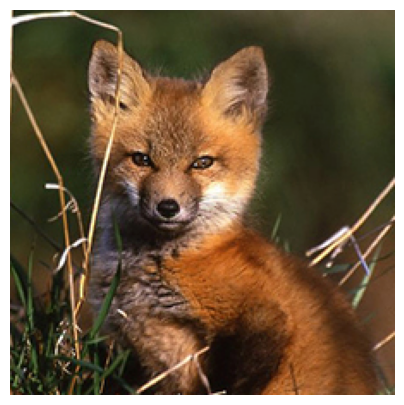

In [4]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = load_image(img_url=img_url)
# img = load_image(img_path='../assets/224x224/img_0.png')  # local image
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## Encode and Reconstruct

In [5]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 224, 224)
    latent = encoder(img_tensor)[:, 0, :]
    pred_latent = decoder(latent)

/tmp/ipykernel_3037661/1892941174.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rec_img = torch.clamp(rec_img * IN_STD + IN_MEAN, 0, 1)


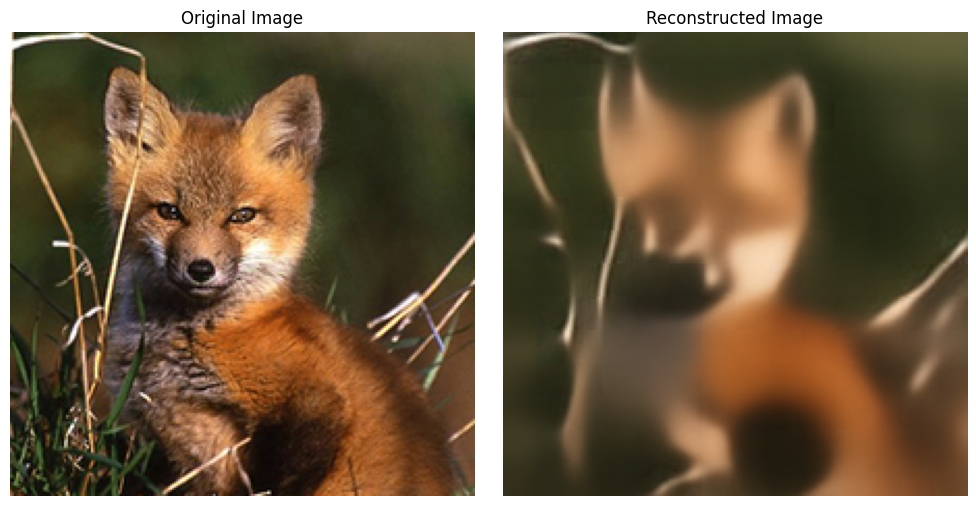

In [7]:
rec_img = unpatchify(pred_latent, decoder.patch_size)[0].detach().cpu().permute(1, 2, 0)
rec_img = torch.clamp(rec_img * IN_STD + IN_MEAN, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img * IN_STD + IN_MEAN)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(rec_img)
plt.title("Reconstructed Image")
plt.axis('off')
plt.tight_layout()

# Process Panorama Images
## Load BtnkMAE Encoder and Decoder

In [8]:
model_size = "large_gan"
act_fn = "relu"
encoder = BtnkMAEEncoder(model_size=model_size, act_fn=act_fn)
decoder = BtnkMAEDecoder(model_size=model_size)
encoder.set_img_size(512)
decoder.set_img_size(512)
checkpoint_path = "../ckpts/habitat/checkpoint-latest.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
encoder.load_state_dict(checkpoint['enc_model'], strict=False)
decoder.load_state_dict(checkpoint['dec_model'], strict=False)

<All keys matched successfully>

## Load Panorama Image

In [28]:
def load_panorama_image(img_path, square=False):
    img = Image.open(img_path).convert("RGB")
    if square:
        img = img.resize((512, 512), Image.BICUBIC)
    img = np.array(img) / 255.
    img = img - IN_MEAN
    img = img / IN_STD
    return img

/tmp/ipykernel_3037661/1687184349.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())


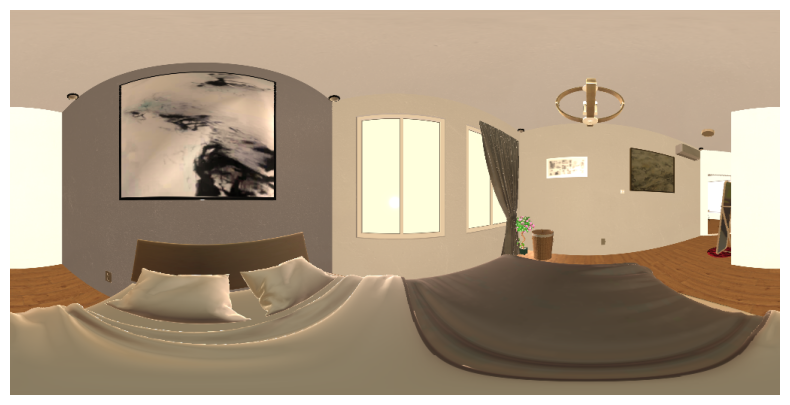

In [48]:
# load an image
img_path = f'../assets/1024x512/img_0.png'
pano_original = load_panorama_image(img_path=img_path)
show_image(torch.tensor(pano_original))

## Encode and Reconstruct Panorama Image

In [49]:
pano_img = load_panorama_image(img_path=img_path, square=True)  # This will be the reshaped panorama image
with torch.no_grad():
    pano_img_tensor = torch.tensor(pano_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 224, 224)
    pano_latent = encoder(pano_img_tensor)[:, 0, :]
    pano_pred_latent = decoder(pano_latent)

/tmp/ipykernel_3037661/103272236.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  pano_rec = torch.clamp(pano_rec * IN_STD + IN_MEAN, 0, 1)


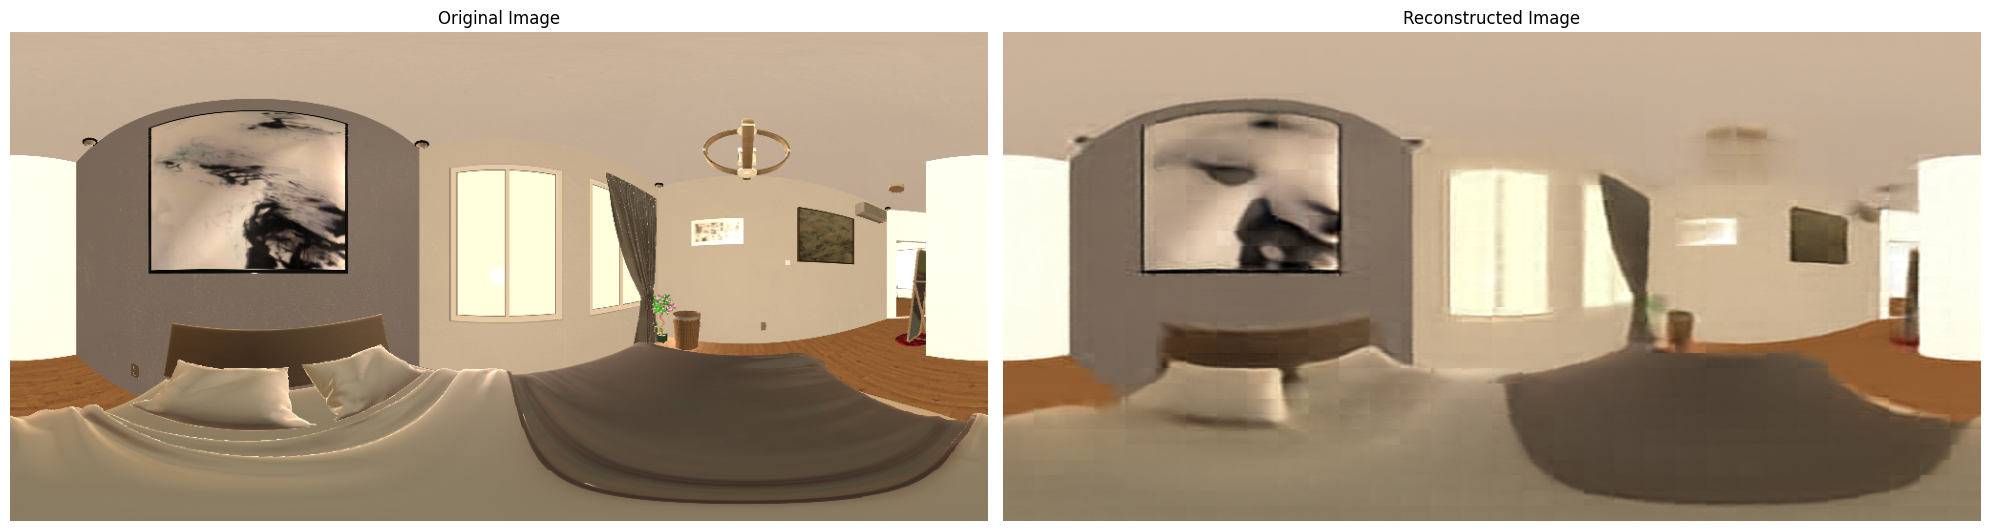

In [50]:
pano_rec = unpatchify(pano_pred_latent, decoder.patch_size)[0].detach().cpu().permute(1, 2, 0)
pano_rec = torch.clamp(pano_rec * IN_STD + IN_MEAN, 0, 1)
pano_rec = Image.fromarray(np.uint8(pano_rec * 255))
pano_rec = pano_rec.resize((1024, 512), Image.BICUBIC)
pano_rec = np.array(pano_rec) / 255.

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pano_original * IN_STD + IN_MEAN)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(pano_rec)
plt.title("Reconstructed Image")
plt.axis('off')
plt.tight_layout()